### Loading Dataset

In [1]:
import pandas as pd

# Load the datasets
mapping_df = pd.read_csv('Mapping.csv')
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

# Display the first few rows of each dataset
mapping_df.head(10)


,Unnamed: 0,emoticons,number
0,0,😜,0
1,1,📸,1
2,2,😍,2
3,3,😂,3
4,4,😉,4
5,5,🎄,5
6,6,📷,6
7,7,🔥,7
8,8,😘,8
9,9,❤,9


In [2]:

train_df.head()

,Unnamed: 0,TEXT,Label
0,0,Vacation wasted ! #vacation2017 #photobomb #ti...,0
1,1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1
2,2,Been friends since 7th grade. Look at us now w...,2
3,3,This is what it looks like when someone loves ...,3
4,4,RT @user this white family was invited to a Bl...,3


In [3]:
test_df.head()

,Unnamed: 0,id,TEXT
0,0,0,Thought this was cool...#Repost (get_repost)・・...
1,1,1,Happy 4th! Corte madera parade. #everytownusa ...
2,2,2,Luv. Or at least something close to it. @ Unio...
3,3,3,There's a slice of pie under that whipped crea...
4,5,5,#thankyou for your thank you We adore you both...


### Data Preprocessing

In [4]:
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning
train_df['cleaned_TEXT'] = train_df['TEXT'].apply(clean_text)
test_df['cleaned_TEXT'] = test_df['TEXT'].apply(clean_text)

train_df[['TEXT', 'cleaned_TEXT']].head(), test_df[['TEXT', 'cleaned_TEXT']].head()

(                                                TEXT  \
 0  Vacation wasted ! #vacation2017 #photobomb #ti...   
 1  Oh Wynwood, you’re so funny! : @user #Wynwood ...   
 2  Been friends since 7th grade. Look at us now w...   
 3  This is what it looks like when someone loves ...   
 4  RT @user this white family was invited to a Bl...   
 
                                         cleaned_TEXT  
 0  Vacation wasted vacation photobomb tired vacat...  
 1  Oh Wynwood you re so funny Wynwood Art ItWasAM...  
 2  Been friends since th grade Look at us now we ...  
 3  This is what it looks like when someone loves ...  
 4  RT this white family was invited to a Black ba...  ,
                                                 TEXT  \
 0  Thought this was cool...#Repost (get_repost)・・...   
 1  Happy 4th! Corte madera parade. #everytownusa ...   
 2  Luv. Or at least something close to it. @ Unio...   
 3  There's a slice of pie under that whipped crea...   
 4  #thankyou for your thank you W

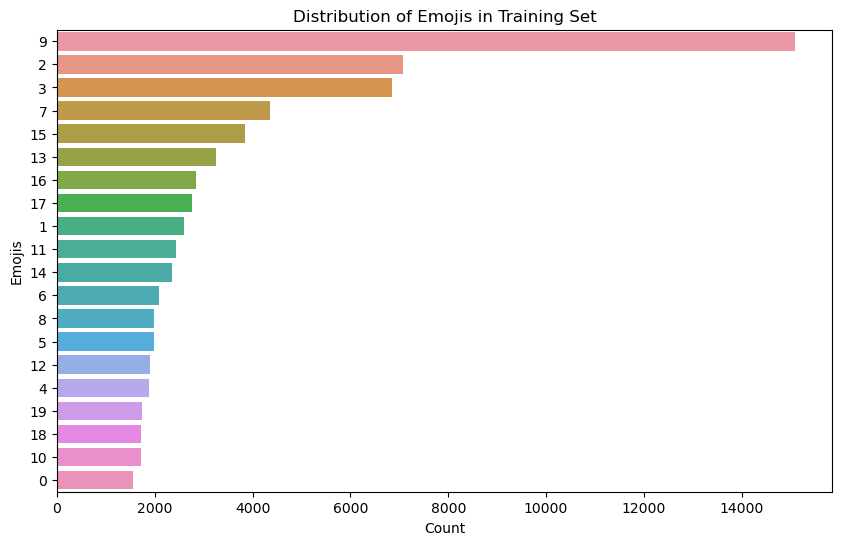

In [6]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

#Visualize the Distribution of Emojis in the Dataset
def plot_emoji_distribution(df, column, title):
    plt.figure(figsize=(10,6))
    sns.countplot(y=column, data=df, order=df[column].value_counts().index)
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Emojis')
    plt.show()

# Plotting the distribution of emojis in the training dataset
plot_emoji_distribution(train_df, 'Label', 'Distribution of Emojis in Training Set')

### Tokenization and Padding

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['cleaned_TEXT'])

X = tokenizer.texts_to_sequences(train_df['cleaned_TEXT'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_TEXT'])

# Padding sequences
X = pad_sequences(X, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# Convert labels to categorical
y = tf.keras.utils.to_categorical(train_df['Label'], num_classes=mapping_df.shape[0])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### Model Building and Training

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(mapping_df.shape[0], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Display the model summary
model.summary()


Epoch 1/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 130s 72ms/step - accuracy: 0.2406 - loss: 2.6705 - val_accuracy: 0.3110 - val_loss: 2.3900
Epoch 2/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 122s 70ms/step - accuracy: 0.3305 - loss: 2.3161 - val_accuracy: 0.3203 - val_loss: 2.3528
Epoch 3/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 109s 62ms/step - accuracy: 0.3665 - loss: 2.1588 - val_accuracy: 0.3203 - val_loss: 2.3633
Epoch 4/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 109s 62ms/step - accuracy: 0.4052 - loss: 2.0290 - val_accuracy: 0.3163 - val_loss: 2.4117
Epoch 5/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 111s 63ms/step - accuracy: 0.4307 - loss: 1.9174 - val_accuracy: 0.3006 - val_loss: 2.5116


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 100, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 100, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 100, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (32, 64)               │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 20)               │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,091,198 (15.61 MB)

 Trainable params: 1,363,732 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,727,466 (10.40 MB)

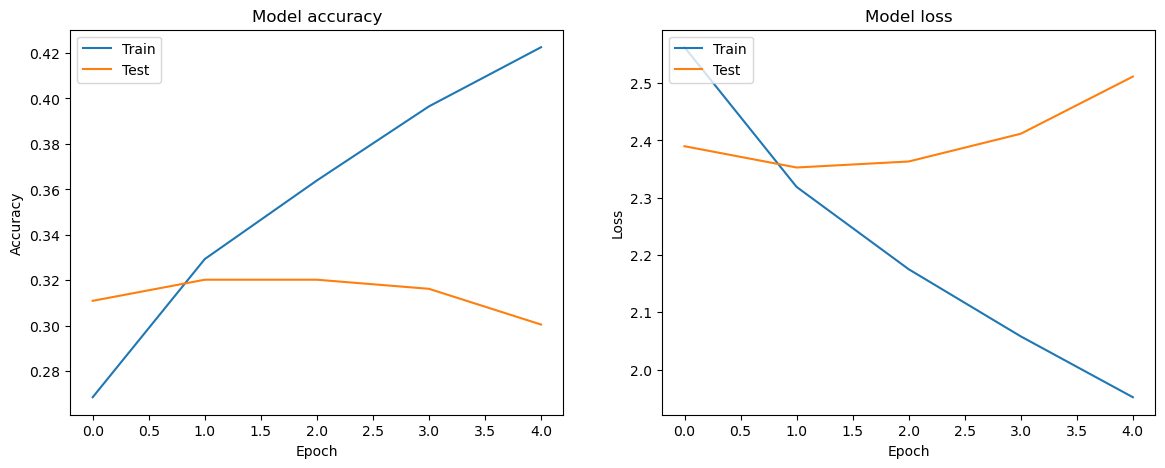

In [10]:
#Visualize the Training History
def plot_training_history(history):
    plt.figure(figsize=(14,5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()
plot_training_history(history)

### Model Evaluation with Additional Metrics

In [12]:
# Evaluate the model on training data
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f'Training Loss: {train_loss}')
print(f'Training Accuracy: {train_accuracy}')

# Predict on training data
y_train_pred = model.predict(X_train).argmax(axis=1)
y_train_true = y_train.argmax(axis=1)

# Classification report for training data
train_report = classification_report(y_train_true, y_train_pred, target_names=mapping_df['emoticons'])
print("Classification Report on Training Data:\n", train_report)

# Precision, Recall, and F1-Score for training data
train_precision = precision_score(y_train_true, y_train_pred, average='weighted')
train_recall = recall_score(y_train_true, y_train_pred, average='weighted')
train_f1 = f1_score(y_train_true, y_train_pred, average='weighted')

print(f'Training Precision: {train_precision}')
print(f'Training Recall: {train_recall}')
print(f'Training F1-Score: {train_f1}')

# Confusion matrix for training data
train_conf_matrix = confusion_matrix(y_train_true, y_train_pred)
print("Confusion Matrix on Training Data:\n", train_conf_matrix)

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Predict on validation data
y_val_pred = model.predict(X_val).argmax(axis=1)
y_val_true = y_val.argmax(axis=1)

# Classification report for validation data
val_report = classification_report(y_val_true, y_val_pred, target_names=mapping_df['emoticons'])
print("Classification Report on Validation Data:\n", val_report)

# Precision, Recall, and F1-Score for validation data
val_precision = precision_score(y_val_true, y_val_pred, average='weighted')
val_recall = recall_score(y_val_true, y_val_pred, average='weighted')
val_f1 = f1_score(y_val_true, y_val_pred, average='weighted')

print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}')
print(f'Validation F1-Score: {val_f1}')

# Confusion matrix for validation data
val_conf_matrix = confusion_matrix(y_val_true, y_val_pred)
print("Confusion Matrix on Validation Data:\n", val_conf_matrix)

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.4923 - loss: 1.7071
Training Loss: 1.702136754989624
Training Accuracy: 0.49385714530944824
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step
Classification Report on Training Data:
               precision    recall  f1-score   support

           😜       0.32      0.15      0.20      1275
           📸       0.44      0.44      0.44      2061
           😍       0.54      0.44      0.49      5668
           😂       0.56      0.74      0.64      5458
           😉       0.34      0.06      0.10      1506
           🎄       0.73      0.85      0.79      1590
           📷       0.42      0.09      0.15      1652
           🔥       0.72      0.70      0.71      3488
           😘       0.47      0.02      0.03      1615
           ❤       0.43      0.83      0.57     12042
           😁       0.28      0.07      0.12      1366
          🇺🇸       0.75      0.71      0.73      1925
           ☀       0.52      0.64      0.58      1539
      

### Prediction on Test Data

In [13]:
# Predict on the test set
predictions = model.predict(X_test)
predicted_labels = predictions.argmax(axis=1)

# Map predicted labels to emojis
predicted_emojis = [mapping_df[mapping_df['number'] == label]['emoticons'].values[0] for label in predicted_labels]

# Add predictions to the test dataframe
test_df['Predicted_Emojis'] = predicted_emojis

# Display the predictions
print(test_df[['TEXT', 'Predicted_Emojis']].head(50))


812/812 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step
                                                 TEXT Predicted_Emojis
0   Thought this was cool...#Repost (get_repost)・・...                📸
1   Happy 4th! Corte madera parade. #everytownusa ...               🇺🇸
2   Luv. Or at least something close to it. @ Unio...                😉
3   There's a slice of pie under that whipped crea...                😍
4   #thankyou for your thank you We adore you both...                ❤
5   the SPECIAL4U Lyric video will be posted on my...                ❤
6   Momma Tanya's In town ! Awesome dinner @user w...                ❤
7                 Thing 1 and Thing 2 @ Huron, Ohio\n                ❤
8   Bday girl and some random @ Sheraton New York ...                😂
9   Always fun with my forever wedding date Congra...                ❤
10  La La Land @ Griffith Park Observatory-Los Ang...                ☀
11          Friends. #Seattle @ Seattle, Washington\n                ❤
12  #GETIT #GOTIT #GOOD #WHATEVERI